# CUNEF MUCD 2022/2023

# Machine Learning
# Análisis de Fraude¶

### Autores:
- Gozde Yazganoglu
- Irma Sanchez

# Importación de Librerías


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.linear_model import TweedieRegressor
from sklearn.pipeline import Pipeline
import pickle
import warnings
warnings.filterwarnings('ignore')

from aux_func import evaluate_model, cargar_modelo

# Cargo de los Datos y Processor

In [3]:
xtrain = pd.read_parquet("../data/processed/xtrain.parquet")
ytrain = pd.read_parquet("../data/processed/ytrain.parquet")
xtest = pd.read_parquet("../data/processed/xtest.parquet")
ytest = pd.read_parquet("../data/processed/ytest.parquet")

In [4]:
#Cargamos pipeline preprocesado
preprocessor = cargar_modelo('../models/preprocessor.pickle')

# Generalized Linear Model

En este problema, no podemos trabajar con un modelo de linear regression por culpa de tenemos un muestra de minoridad. Los supuestos de OLS model no son validos. Por eso podemos trabajar con modelo de GLM.

In [12]:
clf_glm = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', TweedieRegressor(power=1.9, alpha=0.1, max_iter=10000))])

In [13]:
clf_glm.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['step', 'amount',
                                                   'connection_time',
                                                   'oldbalanceOrg', 'age',
                                                   'newbalanceOrig',
                                                   'user_number',
                                                   'user_connections',
                                                   'security_alert',
                                                   'oldbalanceDest',
      

In [14]:
with open('../models/Model_GLM.pickle', 'wb') as f:
    pickle.dump(clf_glm, f)

In [15]:
with open('../models/Model_GLM.pickle', 'rb') as f:
    clf_glm = pickle.load(f)

In [23]:
ypred = clf_glm.predict(xtest)
#ypred_proba = clf_glm.predict_proba(xtest)


NameError: name 'ypred_proba' is not defined

In [19]:
# Adjusting threshold
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

NameError: name 'ypred_proba' is not defined

In [20]:
# Adjusting threshold
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

NameError: name 'ypred_proba' is not defined

ROC CURVE

NameError: name 'fpr' is not defined

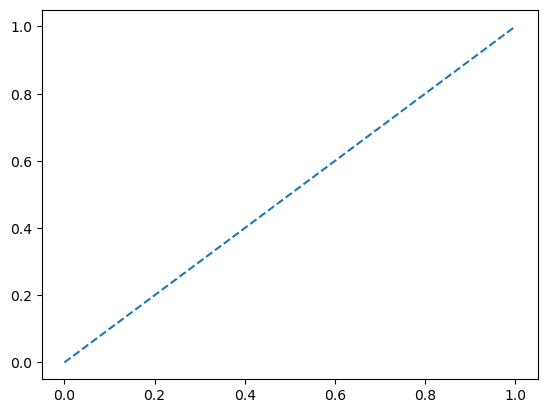

In [24]:
import matplotlib.pyplot as plt
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='GLMlassifier')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [22]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.000000, G-Mean=0.504


In [ ]:
PR CURVE

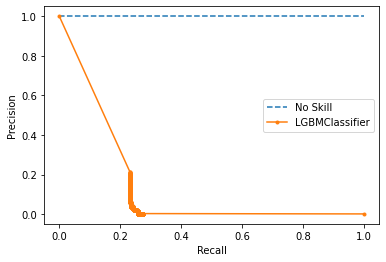

In [30]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(ytest, yhat)
# plot the roc curve for the model
no_skill = len(ytest[ytest==1]) / len(ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='LGBMClassifier')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=1.000000, F-Score=0.222


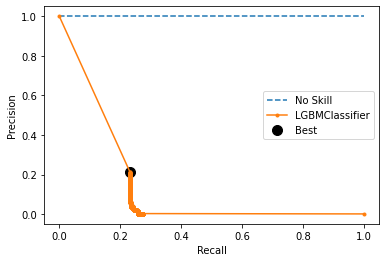

In [31]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(ytest[ytest==1]) / len(ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='LGBMClassifier')
plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [25]:
# evaluate the model
score = f1_score(ytest, ypred)
print('F-Score: %.5f' % score)

F-Score: 0.11623


In [ ]:
CUMULATIVE GAINS CURVE

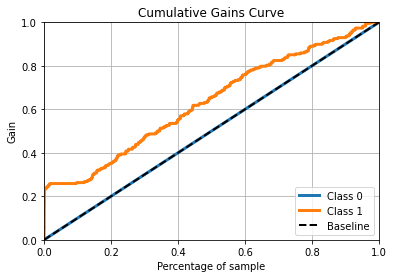

In [26]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(ytest, ypred_proba)
plt.show()

In [ ]:
LIFT CURVE

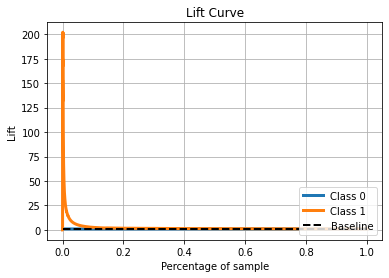

In [27]:
skplt.metrics.plot_lift_curve(ytest, ypred_proba)
plt.show()